
<span style="color:red">
    Dies ist eine vorläufige Version zu Demonstrationszwecken im Rahmen der Vorlesung "Digitalisierung im Sport".
    </span>

# Auswertung von Positionsdaten am Beispiel Handball
Wir zeigen dir hier beispielhaft, wie man Positionsdaten auswerten kann. Dafür steht uns eine Datei von einem Handballspieler zur Verfügung. Exemplarisch wollen wir dir zeigen, wie man aus x-,y-Koordinaten die zurückgelegte Distanz, Geschwindigkeit, die Distanz in verschiedenen Geschwindigkeitszonen und die Metabolic Power (Vgl. Osgnach et al, 2018) berechnet. Dafür nutzen wir dieses Notebook in der Programmiersprache Python. Du kannst die Blöcke einzeln ausführen und den Input verändern (z.B. andere Geschwindigkeitszonen). Viel Spass beim Ausprobieren! 

# Import von Softwarepaketen
Vorab müssen Softwarepakete geladen werden - den Schritt kannst du zunächst ohne zu hinterfragen ausführen. Nach `import` steht das zu ladende Paket. Nach `as` kannst du einen Namen festlegen, wie Funktionen aus dem Paket aufgerufen werden sollen. Mit `numpy` werden grundlegende Rechnungen (Lineare Algebra), mit `pandas` Datenverarbeitung (z.B. Laden von CSV-Dateien) und mit `matplotlib` Visualisierungen (Plots) abgedeckt. `scipy.signal` wird für einen Filter den wir später benutzen importiert.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import signal

# Daten einlesen
CSV's sind Textdateien. CSV steht dabei für comma separated values. In der Tat sind die einzelnen Werte in unserer Beispielsdatei mit dem Semikolon ";" getrennt, daher muss die Funktion angepasst werden. Der Pfad für die Datei ist in diesem Projekt hinterlegt, Wir lesen die Daten ein und speichern sie unter "D" (wie data) ab und rufen sie danach direkt auf:

In [2]:
D=pd.read_csv('../input/positionsdaten-bsp/Postionsdaten_Beispiel.csv', delimiter=';')
D

,ts,t,x,y,z,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,quat_1,quat_i,quat_j,quat_k
0,1.580000e+12,09.01.2020 18:06,NaN,NaN,NaN,-0.051,-0.013,1.251,0.187,0.321,-0.031,0.392,0.186,0.484,0.760
1,1.580000e+12,09.01.2020 18:06,NaN,NaN,NaN,0.039,-0.037,1.347,0.172,0.225,0.125,0.395,0.179,0.486,0.759
2,1.580000e+12,09.01.2020 18:06,NaN,NaN,NaN,0.107,-0.003,1.511,0.197,0.130,0.255,0.398,0.171,0.481,0.762
3,1.580000e+12,09.01.2020 18:06,NaN,NaN,NaN,0.114,0.110,1.701,0.239,0.128,0.262,0.399,0.169,0.472,0.768
4,1.580000e+12,09.01.2020 18:06,NaN,NaN,NaN,0.123,0.179,1.732,0.307,0.211,0.115,0.398,0.169,0.462,0.774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473468,1.580000e+12,09.01.2020 19:47:37.070,NaN,NaN,NaN,0.035,0.010,0.972,-0.025,-0.119,-1.164,-0.852,-0.485,0.138,0.139
473469,1.580000e+12,09.01.2020 19:47:37.083,NaN,NaN,NaN,0.027,0.006,0.908,0.065,-0.072,-1.091,-0.848,-0.489,0.150,0.140
473470,1.580000e+12,09.01.2020 19:47:37.096,NaN,NaN,NaN,-0.002,-0.005,0.835,0.162,-0.044,-1.021,-0.841,-0.497,0.155,0.145
473471,1.580000e+12,09.01.2020 19:47,NaN,NaN,NaN,0.001,0.004,0.796,0.256,-0.021,-0.971,-0.834,-0.507,0.158,0.152


# Entfernen der IMU-Daten
Wir haben 15 Spalten: ts und t zeigen uns die Zeit an, x / y / z sind die berechneten Positionsdaten des LPS-Systems, danach folgen die Daten des IMU-Sensors. Die IMU's messen mit einer höheren Frequenz; die Werte sind noch nicht synchronisiert, daher erscheinen `NaN`'s (not a number) in unserer Tabelle. Man kann die Daten auf eine beliebige Frequenz umrechnen (interpolieren) und so synchronisieren - um es nicht zu kompliziert zu machen lassen wir die IMU-Werte erstmal außen vor und entfernen diese. Dafür suchen wir alle Werte in der X-Spalte, die keine NaN's sind. Du kannst eine beliebige Spalte aus der Tabelle mit ihrem Namen aufrufen, z.B. "D.x":

In [3]:
D = D[~np.isnan(D.x)]
D

,ts,t,x,y,z,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,quat_1,quat_i,quat_j,quat_k
5,1.580000e+12,09.01.2020 18:06,22.020,-13.720,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1.580000e+12,09.01.2020 18:06,21.927,-13.670,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,1.580000e+12,09.01.2020 18:06,21.837,-13.622,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,1.580000e+12,09.01.2020 18:06,21.746,-13.572,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,1.580000e+12,09.01.2020 18:06,21.654,-13.517,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473449,1.580000e+12,09.01.2020 19:47,-6.638,-0.953,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473455,1.580000e+12,09.01.2020 19:47,-6.574,-0.924,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473460,1.580000e+12,09.01.2020 19:47,-6.514,-0.898,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473466,1.580000e+12,09.01.2020 19:47:37.057,-6.459,-0.868,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Beachte dabei, dass der Datensatz von 473.473 auf 82.593 Reihen geschrumpft ist. 

Als nächstes gucken wir uns die x- und y- Koordinate an (Vogelperspektive). Der Befehl plot erwartet erst die Werte für die x-Achse, danach Wertte für die y-Achse. Der Punkt (0|0) ist die Spielfeldmitte. Ein Handballfeld ist 40m lang und 20m breit, daher begrenzen wir beide Achsen. Vorab speichern wir x und y als arrays ab um besser mit ihnen rechnen zu können:

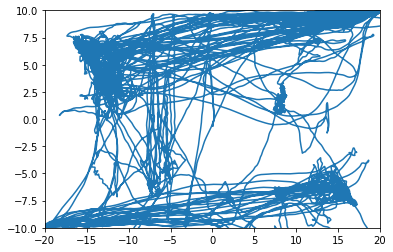

In [4]:
x=np.array(D.x)
y=np.array(D.y)

plt.plot(x,y);

plt.xlim([-20,20]);
plt.ylim([-10,10]);


# Distanz berechnen
Wie berechnet man die Entfernung in der Ebene von einem Punkt zum Anderen? Richtig, Pythagoras ist dein Freund! Du hast zwei Punkte $ P_1 ( x_1 | y_1 ) ; P_2 ( x_2 | y_2 ) $. Nimmst du die x- und y-Komponenten beider Punkten erhältst du ein rechtwinkliges Dreieck, womit $ a^2 + b^2 = c^2 $ bzw. in unserem Fall $ \Delta x^2 + \Delta y^2 = s^2 $ mit $ \Delta x = x_2 - x_1 ;\Delta y = y_2 - y_1  $ und $ s $ der gewünschten Distanz. Es folgt: 

$$
\sqrt {\Delta x^2 + \Delta y^2}  = s
$$

Zunächst schauen wir uns eine beliebige Strecke an und definieren zwei beliebige Datenpunkte in `I`. Daraufhin berechnen wir $ dx $ , $ dy $ und anschließend $ s $.

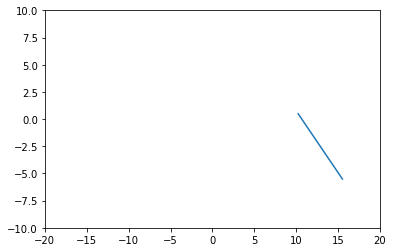

In [5]:
I=[100,200]
plt.plot(x[I],y[I]);

plt.xlim([-20,20]);
plt.ylim([-10,10]);

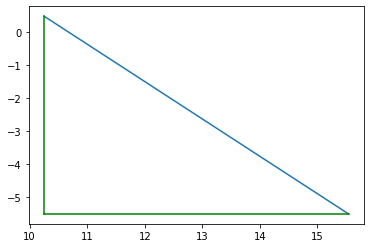

In [6]:
X=x[I]
xconst=X.copy();
xconst[0]=xconst[1];
Y=y[I]
yconst=Y.copy();
yconst[1]=yconst[0];


plt.figure();
plt.plot(x[I],y[I]);
plt.plot(X,yconst,'g',xconst,Y,'g');

In [7]:
dx=np.diff(x[I])
dy=np.diff(y[I])

s=np.sqrt(dx**2+dy**2)

In [8]:
print('x1 =',x[I][0])
print('x2 =',x[I][1])
print('y1 =',y[I][0])
print('y2 =',y[I][1])


print('dx = ', dx[0])
print('dy = ', dy[0])

print('s = sqrt ( dx² + dy²) =', s[0])

x1 = 15.539000000000001
x2 = 10.253
y1 = -5.5120000000000005
y2 = 0.49
dx =  -5.286000000000001
dy =  6.002000000000001
s = sqrt ( dx² + dy²) = 7.9978622143670375


Numpy macht das Rechnen mit Vektoren einfach. Unsere vorab bestimmten x- und y-Koordinaten haben wir als einzelne Spalten extrahiert und so im n x 1 (Reihe x Spalte) - Vektorenformat. Wir können nun unsere Rechnung einfach übertragen und die Differenz von einer Koordinate zur nächsten berechnen - und die Distanz! Wir schauen uns die Gesamtdistanz und die entlang der aufgenommenen Daten kumulierte Distanz  mit `cumsum` ( = cumulative sum - ja, das ist ein wirklich bescheiden gewählter Name...) an. 

Total Distance =  5093.891660347032 m


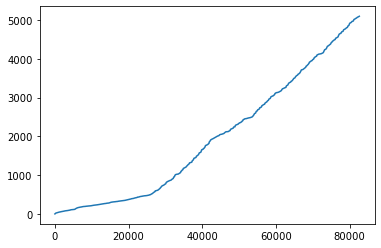

In [9]:
dx=np.diff(x)
dy=np.diff(y)
ds=np.sqrt(dx**2+dy**2)

plt.plot(np.cumsum(ds));
print('Total Distance = ',sum(ds), 'm')

# Geschwindigkeit berechnen
Geschwindigkeit definiert sich durch die zurückgelegte Distanz pro Zeiteinheit - hier in der Einheit Meter pro Sekunde [m/s]. Somit gilt $ v = \Delta s / \Delta t $. Wir haben $ \Delta s $; $\Delta t $ ergibt sich aus der sampling rate. In diesem Fall erhalten wir 15.15 Werte pro Sekunde:

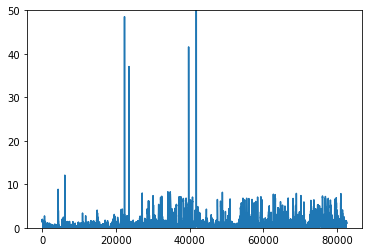

In [10]:
ts=1/15.15
v=ds/ts

plt.plot(v);
plt.ylim(0,50);

# Tiefpassfilter
10 m/s entsprechen 36 km/h - das ist in etwa die Grenze plausibler Werte. Durch Messartefakte kommen hier teilweise höhere Werte zustande. Wir wenden einen Tiefpassfilter an. Wir gehen dabei nicht auf die Details ein. Mit nur ein paar Zeilen an Code können wir die meisten Artefakte eliminieren:

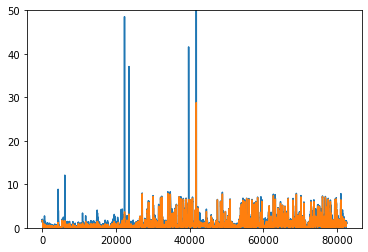

In [11]:
fs=1/ts
fc=0.5
Wn=fc/(fs/2)

m, n = signal.butter(3,Wn)
vf = signal.filtfilt(m, n, v)

plt.plot(v);
plt.plot(vf);
plt.ylim(0,50);

Der letzte Ausreißer entsteht durch die Halbzeitpause, in der eine Datenlücke entstanden ist. Um das Problem zu beheben setzen wir unelegant die Obergrenze der Geschwindigkeit auf 10 m/s fest:

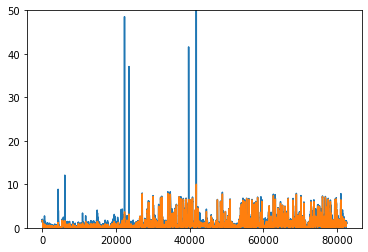

In [12]:
vf[vf>10]=10

plt.plot(v);
plt.plot(vf);
plt.ylim(0,50);

# Beschleunigung
Beschleunigung ist Geschwindigkeitsänderung pro Zeiteinheit - $ \Delta v / \Delta s = a $. Nichts neues, wir filtern direkt und setzen das Maximum betragsmäßig auf 5 m/s² fest:

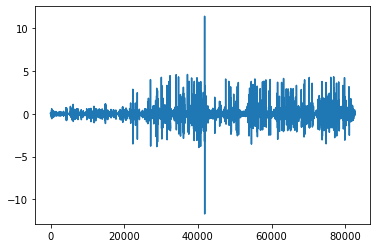

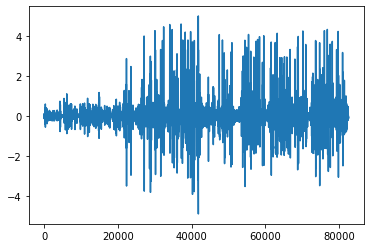

In [13]:
a=np.diff(vf)/ts
af=signal.filtfilt(m, n, a)


plt.plot(af);

af[abs(af)>5]=5
plt.figure();
plt.plot(af);


# Geschwindigkeitszonen



# Metabolic Power
Der Energieverbrauch bei konstanten Laufgeschwindigkeiten auf derselben Distanz ist gleich - ein Mehrverbrauch an Energie entsteht durch Geschwindigkeitsvariation (Beschleunigungen). Mit der Formel von Osgnach und di Prampero lässt sich der spontane Energieverbrauch (vergleichbar mit der Energiebereitstellung durch ATP auf Molekularebene) durch Geschwindigkeit UND Beschleunigung abschätzen. Verglichen wird beschleunigtes / entschleunigtes Laufen mit Bergauf- / Bergabläufen - dabei wird die Beschleunigung in einem biomechanischen Vergleich einer Steigung gleichgesetzt und als `Equivalent Slope (ES)` ausgedrückt. Die Energiekosten für konstantes Laufen (Beschleunigung gleich Null) werden in diesem Beispiel mit $ EC_0 = 4.35  J kg^-1 m^-1 $ angesetzt. Wir setzen unsere Werte in die Formel ein und berechnen die Energiekosten pro Wegeinheit $ EC_r [J * kg^-1 * m^-1] $ und die Energiekosten pro Zeiteinheit  - die Metabolic Power in der Einheit  $ J  * s^-1 * kg^-1 $ oder $ W * kg^-1 $:


$$
EC_r= 155.4 * ES^5 - 30.4 * ES^4 - 43.3 * ES^3 + 46.3 * ES^2 + 19.5 * ES + EC_0 ) * EM
$$

$$
EM= ( ( a^2 / g^2 ) +1 )^{0.5} 
$$






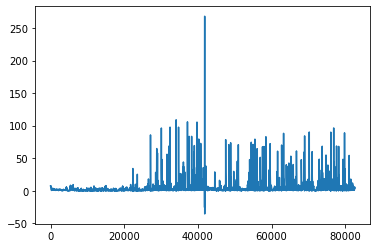

In [14]:
vf=np.delete(vf,0)
g = 9.81
EC = 4.35
ES = af / g

EM = ( ( af**2 / g**2 ) + 1)**(0.5) 

ECr = (155.4 * ES**5 - 30.4 * ES**4 - 43.3 * ES**3 + 46.3 * ES**2 + 19.5 * ES + EC ) * EM

MP = ECr * vf

plt.plot(MP);


Noch nicht ganz sauber, die Halbzeitpause ärgert uns hier schon wieder! Lassen wir es hier aber mal gut sein für's Erste ...

# Fazit
Du kannst mit diesem Code eine einzelne Datei bearbeiten und dir Parameter wie Gesamtdistanz, Distanz in Geschwindigkeitszonen, Energieverbrauch für eine Trainingseinheit, -sequenz, ein Spiel etc. berechnen. Natürlich können weitere Funktionen ergänzt werden. Es gibt aber noch mehr zu tun: Im Monitoring verschaffst du dir einen Überblick über mehrere Einheiten und versuchst diese im Längsschnitt zu interpretieren. Auch dieser Prozess lässt sich automatisieren. Warum das Ganze nicht per Hand in Excel berechnen? Der Vorteil liegt hier auf der Hand: Der geschriebene Code lässt sich durch ein paar Zeilen ergänzen und kann auf beliebig viele Dateien angewendet werden - Zeitersparnis hoch zehn! Mehr Zeit zum Nachdenken und interpretieren der Daten!